<a href="https://colab.research.google.com/github/DarioDell/convolutional_neural_networks-CNN-/blob/main/Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Localization

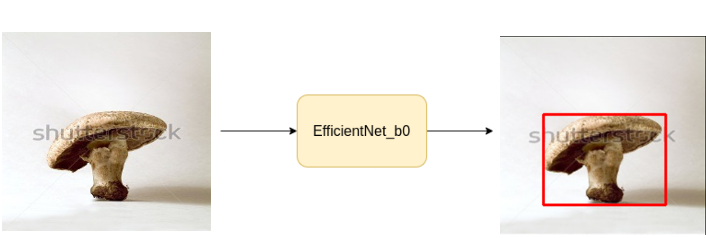

In [256]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations

!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-q5mxx15c
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-q5mxx15c
  Resolved https://github.com/albumentations-team/albumentations to commit 81bf9e28d4ad136b8357a10bddfd6d8edd3424ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [257]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [258]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from torch import nn
import timm

In [259]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [260]:

CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset'
DEVICE = 'cuda'


DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
NUM_EPOCHS = 100
MODEL_NAME = 'tf_efficientnet_b0_ns'

NUM_COR = 4

In [261]:
df = pd.read_csv(CSV_FILE)
df

# xmin,ymin,xmax,ymax --> las coordenadas del cuadro delimitador (bounding box)
# No me voy a centrar en el label, ya que no es un problema de clasificación. Es una tarea de localización, me interesan las coordenadas

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

A continuación, la idea es ver como los bounding boxes están definidos sobre las imágenes. Es útil para asegurarse de que los datos de entrenamiento (imágenes y anotaciones) están correctamente alineados.

/content/object-localization-dataset/train_images/mushroom_12.jpg


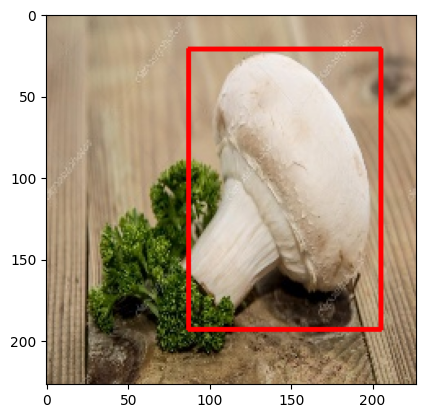

In [262]:
import os

row = df.iloc[5]
# s.path.join para asegurarse de que la ruta sea correcta
file_path = os.path.join(DATA_DIR, row.img_path)

# Print la ruta correcta
print(file_path)

# Cargar la imagen usando la ruta corregida
img = cv2.imread(file_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (int(row.xmin), int(row.ymin))
pt2 = (int(row.xmax), int(row.ymax))
bnd_box_img = cv2.rectangle(img,pt1, pt2,(255,0,0),2)
plt.imshow(bnd_box_img)
plt.show()

In [263]:
# training / validation

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

Augmentation es una técnica utilizada para aumentar la cantidad y diversidad de los datos de entrenamiento, aplicando transformaciones (como rotaciones, recortes, cambios de color, etc.) a las imágenes de forma que el modelo generalice mejor.<br>
Hay que tener en cuenta que la forma en que se aplica augmentation depende del tipo de tarea: No es lo mismo aplicar augmentation a un problema de clasificación que a uno de detección o localización de objetos.<br>
En el caso de problemas de clasificación, los augmentations cambian la apariencia global de la imagen, pero la etiqueta de la imagen sigue siendo la misma.<br>
Mientras que en los casos de localización o detección, los augmentations no solo afectan la imagen, sino que también requieren que se actualice el cuadro delimitador (bounding boxes) para que correspondan a las transformaciones aplicadas.


In [264]:
import albumentations as A

In [265]:
# Se aplican transformaciones (augmentations) a las imágenes y bounding boxes para mejorar la robustez del modelo durante el entrenamiento.


train_augs = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5)

    # Al ser un problema de detección/localización de objetos necesito introducir los paremetros para el cuadro delimitador
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(224, 224)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

Aquí se busca crear un dataset personalizado para entrenar el modelo de detección de objetos, aplicando transformaciones (augmentations) a las imágenes y bounding boxes.

In [266]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    xmins = row.xmin
    xmaxs = row.xmax
    ymins = row.ymin
    ymaxs = row.ymax

    bbox = [[xmins, ymins, xmaxs, ymaxs]]


    img_path = os.path.join(DATA_DIR, row.img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      augmented = self.augmentations(image=img, bboxes=bbox, class_labels=[row.label])
      img = augmented['image']
      bbox = torch.tensor(augmented['bboxes'][0], dtype=torch.float32)

    img = img.astype(np.float32)
    img /= 255.0
    img = img.transpose(2, 0, 1)
    img = torch.tensor(img, dtype=torch.float32)

    return img, bbox

In [267]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [268]:
print(f'Total examples in the Trainset : {len(trainset)}')
print(f'Total examples in the Validset : {len(validset)}')

Total examples in the Trainset : 148
Total examples in the Validset : 38


Shape of image : torch.Size([3, 224, 224])
Shape of bbox : torch.Size([4])


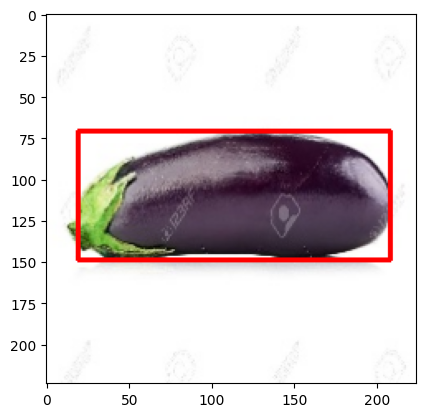

In [269]:
img, bbox = trainset[0]
print(f'Shape of image : {img.shape}')
print(f'Shape of bbox : {bbox.shape}')

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

Los modelos de deep learning generalmente no se entrenan con todas las imágenes del dataset a la vez (lo que se llamaría entrenamiento por batch completo o "batch training"), sino que se entrenan en minilotes. Un minilote es un subconjunto de datos que se alimenta al modelo en una sola pasada (forward y backward propagation).

En este caso el dataset cuenta con 186 imágenes y el batch_size es 16, eso significa que el modelo procesará 16 imágenes a la vez. Así, después de procesar 16 imágenes, actualizará los pesos y luego pasará al siguiente lote de imágenes.

trainloader: Carga los datos de entrenamiento (trainset) en lotes de tamaño 16. Durante el entrenamiento, los datos se cargan de manera aleatoria (es decir, *shuffle=True*), lo que significa que el orden de las imágenes se mezcla en cada época. Esto ayuda a que el modelo no se acostumbre al orden en el que se ven las imágenes, mejorando la capacidad de generalización.

validloader: Carga los datos de validación (validset) en lotes de tamaño 16. Aquí, el argumento *shuffle=False* indica que no se deben mezclar los datos, ya que durante la evaluación (validación), pretendo que los datos se procesen en el mismo orden para obtener resultados consistentes.

In [270]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size= 16, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size= 16, shuffle=False)

In [271]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [272]:
for images, bboxes in trainloader:
  print("Shape of one batch images : {}".format(images.shape))    # [batch_size, num_channels, height, width]
  print("Shape of one batch bboxes : {}".format(bboxes.shape))
  break;


Shape of one batch images : torch.Size([16, 3, 224, 224])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

En este caso voy a utilizar el modelo **EfficientNet-B0** de la libreria *timm*

In [273]:
class ObjLocModel(nn.Module):      # nn.Module: Es la clase base de todos los modelos en PyTorch, y ObjLocModel hereda de ella

  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model('tf_efficientnet_b0_ns', pretrained=True, num_classes=4)   # El término "backbone" se refiere a la red principal que extrae características de la imagen. En este caso, es el modelo EfficientNet-B0.
                                                                                              # num_classes=4: Aquí la red se ajusta para tener una salida de 4 valores en lugar de una salida de clasificación
  def forward(self, images, gt_bboxes = None):
                                                # images: Es el lote de imágenes de entrada, y pasan por el modelo EfficientNet (self.backbone) para generar las predicciones de bounding boxes.
    bboxes = self.backbone(images)

  # Cálculo de la pérdida solo cuando es necesario (en entrenamiento): La pérdida se calcula solo cuando se proporcionan etiquetas verdaderas (gt_bboxes)
    if gt_bboxes != None:                      # son las coordenadas verdaderas de los objetos en la imagen que se proporcionan solo durante el entrenamiento.
      loss = nn.MSELoss()(bboxes, gt_bboxes)   # calcular la pérdida entre las coordenadas predichas por el modelo (bboxes) y las coordenadas verdaderas (gt_bboxes).

      return bboxes, loss

    return bboxes


In [274]:
model = ObjLocModel()
model.to(DEVICE)


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16

Se genera una imagen aleatoria con dimensiones 1x3x140x140. 1 es el tamaño del lote, es decir, una imágen. 3 hace referencia al formato RGB (color). 140 y 140 son las dimensiones de la imagen, tiene un tamaño de 140x140 píxeles.

Se pasa esa imagen al modelo.

*.shape* devuelve las dimensiones de la salida del modelo, indicando que el modelo ha devuelto un conjunto de 4 coordenadas para el bounding box de la imagen procesada.

In [275]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

La siguiente función realiza el entrenamiento del modelo para un número definido de lotes de datos, calculando y acumulando la pérdida a medida que avanza. Al final, retorna la pérdida promedio del entrenamiento, que es útil para monitorear el rendimiento del modelo a lo largo de las épocas.

In [276]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):   # Iteración sobre el Dataloader
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()   # Se restablecen los gradientes acumulados del optimizador a cero
    loss.backward()         # Se calculan los gradientes de la pérdida respecto a los parámetros del modelo
    optimizer.step()        # Se actualizan los parámetros del modelo utilizando

    total_loss += loss.item()      # Se acumula la pérdida total en total_loss para después calcular la pérdida media

  return total_loss / len(dataloader)

La diferencia principal de la siguiente función con respecto a la función de entrenamiento es que no se actualizan los pesos del modelo y se desactivan los gradientes, lo que lo hace más eficiente en términos de memoria y procesamiento.

In [277]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()              # Se establece el modelo en modo de evaluación con model.eval(), lo que es importante para desactivar capas como Dropout y Batch Normalization, que no deben aplicarse durante la evaluación.

  with torch.no_grad():            # para desactivar el cálculo de gradientes, lo que reduce el uso de memoria y acelera la evaluación
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [278]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

# lr: tasa de aprendizaje (learning rate) del optimizador es un hiperparámetro crucial que determina el tamaño de los pasos que el optimizador da al actualizar los parámetros del modelo

A continuación, se entrena el modelo durante un número específico de epochs, se evalua su rendimiento en un conjunto de validación y se guarda el modelo con la mejor capacidad de generalización (es decir, el que tiene la menor pérdida de validación). Este enfoque ayuda a prevenir el sobreajuste (overfitting) y asegura que se tenga un modelo que funciona bien en datos no vistos. La impresión de las pérdidas de entrenamiento y validación después de cada epoch proporciona información sobre el progreso del entrenamiento y la efectividad del modelo.








In [279]:
best_valid_loss = np.inf            # Se inicializa best_valid_loss a infinito (np.inf)

for i in range(NUM_EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:                   # Se verifica si la pérdida de validación actual (valid_loss) es menor que la mejor pérdida de validación registrada (best_valid_loss)
    torch.save(model.state_dict(), 'best_model.pt')  # Si es así, se guarda el estado del modelo (los parámetros aprendidos) en un archivo llamado 'best_model.pt'
    print("WEIGHT ARE SAVED!")
    best_valid_loss = valid_loss

  print(f'Epoch : {i+1}')                  # Se imprime el número de epoch actual
  print(f'Train Loss : {train_loss:.4f}')
  print(f'Valid Loss : {valid_loss:.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 1
Train Loss : 13236.5455
Valid Loss : 2889.6127


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 2
Train Loss : 9458.1775
Valid Loss : 1606.7308


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3
Train Loss : 7839.8406
Valid Loss : 5163.2293


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4
Train Loss : 6752.7071
Valid Loss : 5841.7012


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5
Train Loss : 5827.2336
Valid Loss : 4574.3185


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6
Train Loss : 5886.5834
Valid Loss : 5057.3908


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7
Train Loss : 4583.9751
Valid Loss : 3200.3132


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8
Train Loss : 4526.2824
Valid Loss : 4399.0264


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9
Train Loss : 4284.0693
Valid Loss : 3046.2767


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10
Train Loss : 3982.5497
Valid Loss : 2521.5413


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11
Train Loss : 3262.0309
Valid Loss : 2711.1736


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12
Train Loss : 3093.7885
Valid Loss : 2032.0254


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 13
Train Loss : 2729.0948
Valid Loss : 1310.5765


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14
Train Loss : 2781.0848
Valid Loss : 1354.2779


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 15
Train Loss : 2551.2711
Valid Loss : 742.6223


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16
Train Loss : 2245.8122
Valid Loss : 828.3214


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17
Train Loss : 2224.7879
Valid Loss : 1159.3755


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18
Train Loss : 2378.6557
Valid Loss : 1403.3691


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19
Train Loss : 1972.0386
Valid Loss : 2093.5818


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 20
Train Loss : 1797.4503
Valid Loss : 691.4064


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21
Train Loss : 1912.1062
Valid Loss : 969.0049


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22
Train Loss : 1648.1142
Valid Loss : 764.4590


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23
Train Loss : 1811.4572
Valid Loss : 1288.2311


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24
Train Loss : 1424.5005
Valid Loss : 1007.2643


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 25
Train Loss : 1687.1402
Valid Loss : 423.4719


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 26
Train Loss : 1497.1751
Valid Loss : 289.2036


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27
Train Loss : 1798.0329
Valid Loss : 708.0561


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28
Train Loss : 1231.8218
Valid Loss : 383.7268


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29
Train Loss : 1746.7725
Valid Loss : 365.7829


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30
Train Loss : 1921.7146
Valid Loss : 557.5443


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31
Train Loss : 1609.5259
Valid Loss : 470.2280


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32
Train Loss : 1688.2496
Valid Loss : 527.5783


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33
Train Loss : 1523.5261
Valid Loss : 700.8844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34
Train Loss : 1322.7776
Valid Loss : 747.3406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35
Train Loss : 1553.9030
Valid Loss : 672.5603


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36
Train Loss : 1245.2983
Valid Loss : 399.3505


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37
Train Loss : 1346.1931
Valid Loss : 519.7596


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38
Train Loss : 1197.4239
Valid Loss : 409.0502


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39
Train Loss : 1387.1384
Valid Loss : 451.8976


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40
Train Loss : 1510.4732
Valid Loss : 764.2755


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 41
Train Loss : 1197.9958
Valid Loss : 513.2061


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 42
Train Loss : 1388.6185
Valid Loss : 454.2950


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 43
Train Loss : 1483.0608
Valid Loss : 498.1404


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 44
Train Loss : 1511.9636
Valid Loss : 563.1830


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 45
Train Loss : 1164.4161
Valid Loss : 898.6913


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 46
Train Loss : 1511.2833
Valid Loss : 569.0043


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 47
Train Loss : 1644.2125
Valid Loss : 389.4528


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 48
Train Loss : 1557.8491
Valid Loss : 336.2545


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 49
Train Loss : 1863.1474
Valid Loss : 461.8333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 50
Train Loss : 1243.6558
Valid Loss : 869.0395


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 51
Train Loss : 1352.2466
Valid Loss : 714.5069


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 52
Train Loss : 1661.0869
Valid Loss : 909.7477


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 53
Train Loss : 1478.5056
Valid Loss : 807.7199


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 54
Train Loss : 1354.0637
Valid Loss : 591.8647


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 55
Train Loss : 1643.3764
Valid Loss : 509.3713


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 56
Train Loss : 1470.5687
Valid Loss : 586.4244


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 57
Train Loss : 1390.8743
Valid Loss : 790.2517


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 58
Train Loss : 1436.2339
Valid Loss : 521.3389


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 59
Train Loss : 1630.7640
Valid Loss : 910.9486


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 60
Train Loss : 1441.4198
Valid Loss : 495.3383


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 61
Train Loss : 1834.3136
Valid Loss : 672.6535


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 62
Train Loss : 1213.4115
Valid Loss : 473.4288


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 63
Train Loss : 1418.2250
Valid Loss : 619.0493


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 64
Train Loss : 1541.4720
Valid Loss : 535.2608


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 65
Train Loss : 1271.6156
Valid Loss : 412.8060


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 66
Train Loss : 1673.1125
Valid Loss : 347.3058


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 67
Train Loss : 1582.4546
Valid Loss : 493.8476


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 68
Train Loss : 1804.1233
Valid Loss : 563.0119


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 69
Train Loss : 1452.0640
Valid Loss : 766.4922


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 70
Train Loss : 1104.9495
Valid Loss : 371.7890


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 71
Train Loss : 1415.1035
Valid Loss : 354.3480


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 72
Train Loss : 1235.2079
Valid Loss : 487.1116


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 73
Train Loss : 1614.5087
Valid Loss : 424.6505


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 74
Train Loss : 1213.8701
Valid Loss : 233.8169


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 75
Train Loss : 1256.6196
Valid Loss : 302.9101


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 76
Train Loss : 954.7789
Valid Loss : 533.7756


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 77
Train Loss : 1387.6329
Valid Loss : 378.6817


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 78
Train Loss : 1076.9497
Valid Loss : 256.8417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 79
Train Loss : 1245.8191
Valid Loss : 293.4876


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 80
Train Loss : 1612.1507
Valid Loss : 678.2797


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 81
Train Loss : 1713.9606
Valid Loss : 849.1048


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 82
Train Loss : 1463.3187
Valid Loss : 359.6396


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 83
Train Loss : 1106.4028
Valid Loss : 192.6958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 84
Train Loss : 1368.4556
Valid Loss : 264.4925


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 85
Train Loss : 978.0944
Valid Loss : 459.3227


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 86
Train Loss : 1277.8128
Valid Loss : 346.2930


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 87
Train Loss : 1359.2025
Valid Loss : 359.7845


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 88
Train Loss : 996.6561
Valid Loss : 427.7762


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 89
Train Loss : 1137.8815
Valid Loss : 406.8656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 90
Train Loss : 822.9096
Valid Loss : 491.1626


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 91
Train Loss : 1302.0024
Valid Loss : 580.4491


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 92
Train Loss : 988.9225
Valid Loss : 686.1077


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 93
Train Loss : 1348.3775
Valid Loss : 620.3156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 94
Train Loss : 1404.7905
Valid Loss : 541.2223


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 95
Train Loss : 1230.0938
Valid Loss : 605.4460


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 96
Train Loss : 876.2989
Valid Loss : 280.2043


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 97
Train Loss : 941.1664
Valid Loss : 157.9356


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 98
Train Loss : 992.5016
Valid Loss : 242.0491


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 99
Train Loss : 1114.5246
Valid Loss : 219.0919


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 100
Train Loss : 1252.6459
Valid Loss : 215.9906


Para determinar en qué epoch se ha obtenido el mejor resultado durante el entrenamiento, se debe observar los valores de la pérdida de validación (Valid Loss) que se muestran en la salida del entrenamiento. El "mejor resultado"  se refiere al menor valor de la pérdida de validación, ya que esto indica que el modelo está generalizando mejor en el conjunto de validación.

#Inference, visualization

En la etapa de inferencia del modelo entrenado para la localización o detección de objetos tiene el propósito de evaluar cómo el modelo predice las cajas delimitadoras ("bounding boxes") para los objetos en una imagen dada y compararlas con las cajas reales (ground truth).

In [284]:
import utils

<ipython-input-285-d839db3a31e4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))    # Se cargan los parámetros (pesos) en

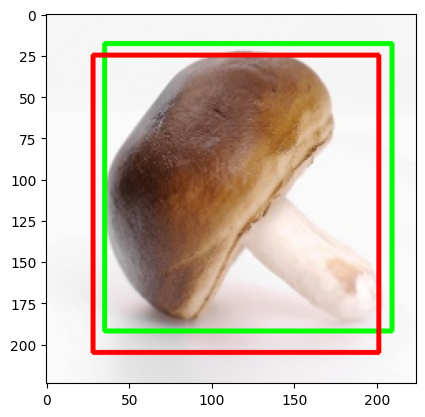

In [285]:
model.load_state_dict(torch.load('best_model.pt'))    # Se cargan los parámetros (pesos) entrenados del archivo 'best_model.pt' para que el modelo sepa cómo procesar los datos
model.eval()                                          #  Se pone el modelo en modo de evaluación

with torch.no_grad():

     image, gt_bbox = validset[2] # (c, h, w)                 # Se extrae una imagen y su correspondiente caja delimitadora real (ground truth) de un conjunto de validación.
     image = image.unsqueeze(0).to(DEVICE) # (1, c, h, w)     # Añade una dimensión extra a la imagen para adaptarse al tamaño que espera el modelo (generalmente necesita un batch de imágenes). Aquí se convierte en una imagen con una dimensión extra para el batch.
     out_bbox = model(image)                                  # El modelo realiza una predicción sobre la imagen y genera una caja delimitadora estimada (out_bbox)

     utils.compare_plots(image, gt_bbox, out_bbox)         # Función para visualizar la comparación entre la caja delimitadora real (gt_bbox) y la caja predicha por el modelo (out_bbox).


# En verde es la caja delimitadora real (ground truth)
# En rojo es la predicción del modelo. Esto permite observar visualmente la precisión del mismo.




Como conclusión se puede afirmar que hay una superposición parcial (cambiar la imagen del 'validset' para ver otra imagen), hay cierta coincidencia entre ambas cajas, pero no es perfecta. La caja roja es no se ajusta completamente a la figura, mientras que la caja verde parece ajustarse mejor a la forma real del objeto.<br>
Esto indica que el modelo predijo incorrectamente el tamaño o la posición del objeto, lo que a mí parecer puede reducir el desempeño general del modelo.
En caso que el proyecto hubiese requerido de una alta precisión (por ejemplo, en un entorno médico o de seguridad), este resultado probablemente sea negativo, porque la predicción no es precisa.<br>
*Pero al ser un problema más flexible, como un detector/localizador genérico donde la exactitud pixel a pixel no es tan crítica, el resultado podría considerarse aceptable.*

# Evaluation

La **evaluación numérica** del modelo a través de la **métrica IoU** sería ideal para dar conclusiones más objetivas

In [286]:
# Función para calcular IoU entre dos cajas delimitadoras
def calculate_iou(gt_bbox, pred_bbox):
    x1_inter = max(gt_bbox[0], pred_bbox[0])
    y1_inter = max(gt_bbox[1], pred_bbox[1])
    x2_inter = min(gt_bbox[2], pred_bbox[2])
    y2_inter = min(gt_bbox[3], pred_bbox[3])

    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height

    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])

    union_area = gt_area + pred_area - inter_area

    iou = inter_area / union_area if union_area != 0 else 0

    return iou

In [287]:
total_iou = 0
n_images = len(validset)

for i in range(n_images):

    # Obtener la imagen y la caja real (ground truth)
    image, gt_bbox = validset[i]

    # Procesar la imagen para el modelo
    image = image.unsqueeze(0).to(DEVICE)

    # Obtener las predicciones de la caja predicha por el modelo
    out_bbox = model(image)
    pred_bbox = out_bbox.detach().cpu().numpy().flatten()  # Convertir tensor a numpy

    # Calcular IoU para esta imagen
    iou = calculate_iou(gt_bbox, pred_bbox)
    total_iou += iou

    print(f"Imagen {i}: IoU = {iou:.2f}")

# Calcular IoU promedio
mean_iou = total_iou / n_images
print(f"Promedio de IoU para todas las imágenes: {mean_iou:.2f}")


Imagen 0: IoU = 0.63
Imagen 1: IoU = 0.85
Imagen 2: IoU = 0.83
Imagen 3: IoU = 0.76
Imagen 4: IoU = 0.85
Imagen 5: IoU = 0.88
Imagen 6: IoU = 0.85
Imagen 7: IoU = 0.81
Imagen 8: IoU = 0.91
Imagen 9: IoU = 0.72
Imagen 10: IoU = 0.46
Imagen 11: IoU = 0.82
Imagen 12: IoU = 0.43
Imagen 13: IoU = 0.87
Imagen 14: IoU = 0.81
Imagen 15: IoU = 0.84
Imagen 16: IoU = 0.80
Imagen 17: IoU = 0.81
Imagen 18: IoU = 0.18
Imagen 19: IoU = 0.85
Imagen 20: IoU = 0.66
Imagen 21: IoU = 0.80
Imagen 22: IoU = 0.79
Imagen 23: IoU = 0.77
Imagen 24: IoU = 0.67
Imagen 25: IoU = 0.82
Imagen 26: IoU = 0.88
Imagen 27: IoU = 0.62
Imagen 28: IoU = 0.83
Imagen 29: IoU = 0.68
Imagen 30: IoU = 0.68
Imagen 31: IoU = 0.62
Imagen 32: IoU = 0.65
Imagen 33: IoU = 0.83
Imagen 34: IoU = 0.94
Imagen 35: IoU = 0.62
Imagen 36: IoU = 0.67
Imagen 37: IoU = 0.88
Promedio de IoU para todas las imágenes: 0.75


Si el **IoU es bajo (por ejemplo, < 0.5)**, se podría concluir que el modelo necesita más ajustes en su precisión. Si el **IoU es alto (por ejemplo, > 0.75)**, se podría decir que el resultado es bastante bueno, a pesar de la diferencia visual.